In [1]:
from nltk.corpus import cess_esp, udhr
from matplotlib import pyplot as plt
from random import randrange, sample
from collections import defaultdict
from nltk import pos_tag
import pandas as pd
import numpy as np
import string
import nltk
import re


# Ulysses Lexical Exploration

> 'Ulysses', by James Joyce, is one of my favorite books. Part of it's claim to fame is the linguistic richness therein. Beyond an immense English vocabulary, Joyce also borrows words from Gaelic, French, Spanish, Italian, and Latin throughout. Even beyond this, Joyce is known as one of the most notorious neologists in literature (Shakespeare sire's us all). His portmanteus, onomatopoeia, and otherwise zany word creations are some of the best displays of his masterfully blended poetic/prosaic style. 



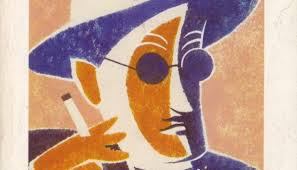



>What follows is a brief exploration using some tools in python into the style and structure of Joyce's classic.

## Data Prep

In [2]:
ulysses = [re.sub(r'\n', ' ', s) for s in nltk.sent_tokenize(open('ulysses.txt', 'r').read())]
ulysses[87:100]


['Thalatta!_ She is our great sweet mother.',
 'Come and look.',
 'Stephen stood up and went over to the parapet.',
 'Leaning on it he looked down on the water and on the mailboat clearing the harbourmouth of Kingstown.',
 '—Our mighty mother!',
 'Buck Mulligan said.',
 'He turned abruptly his grey searching eyes from the sea to Stephen’s face.',
 '—The aunt thinks you killed your mother, he said.',
 'That’s why she won’t let me have anything to do with you.',
 '—Someone killed her, Stephen said gloomily.',
 '—You could have knelt down, damn it, Kinch, when your dying mother asked you, Buck Mulligan said.',
 'I’m hyperborean as much as you.',
 'But to think of your mother begging you with her last breath to kneel down and pray for her.']

>how many <b>sentences</b>, <b>words</b> are there in Ulysses?

In [3]:
print(f'There are {len(ulysses)} sentences in Ulysses, and {sum([len(s.split()) for s in ulysses])} words.')



There are 23641 sentences in Ulysses, and 266103 words.


>and <b>unique</b> words?

In [4]:
u_words = set([w for s in ulysses for w in s.split()])

print(f'There are {len(u_words)} unique words.')

There are 49191 unique words.


>what if we want to do some by-the-<b>chapter</b>, -<b>act</b> analysis? Let's keep the sentence and its <b>location</b> for every chapter head using a regular expression, then do the same for the acts.

In [5]:
chapter_heads = [(s, i) for i, s in enumerate(ulysses) if re.match(r'.*\[ [0-9]+ \] .*', s)]
chapter_heads[:2]


[('[ 2 ]  —You, Cochrane, what city sent for him?', 745),
 ('[ 3 ]  Ineluctable modality of the visible: at least that if no more, thought through my eyes.',
  1243)]

In [6]:
acts_heads = [s for s in chapter_heads if re.match(r'.+\[ [0-9]+ \] .*', s[0])]
acts_heads[:-2]

[('— II —   [ 4 ]  Mr Leopold Bloom ate with relish the inner organs of beasts and fowls.',
  1935),
 ('_Done._   [ 12 ]  I was just passing the time of day with old Troy of the D. M. P. at the corner of Arbour hill there and be damned but a bloody sweep came along and he near drove his gear into my eye.',
  12989)]

In [7]:
print(len(chapter_heads))
print(len(acts_heads))

17
4


>So we see there are <b>18 chapters</b> (17 + 1 for the first one without a heading), and <b>3 acts</b>. (the _Done_ is a bug in our program). We also see that crazy last chapter that's a single sentence, a single stream-of-consciousness. Maybe we should visualize how long the average sentence is per chapter? Let's write a little module that takes the sentences and does this.

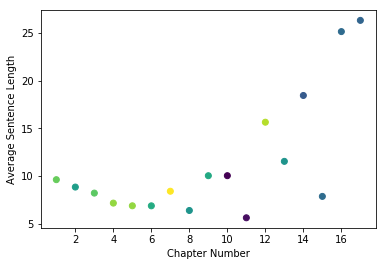

In [8]:
#get the lengths of the sentences in the ranges of the chapter heading locations
#add their average to a list that gets plotted
def plot_uly_sen_lengths(ulysses, chap_or_act):
    
    chapter_heads = [(s, i) for i, s in enumerate(ulysses) if re.match(r'.*\[ [0-9]+ \] .*', s)]
    acts_heads = [s for s in chapter_heads if re.match(r'.+\[ [0-9]+ \] .*', s[0])]
    chap_locs = [s[1] for s in chapter_heads]
    acts_locs = [s[1] for s in acts_heads]
    
    
    locs = acts_locs if chap_or_act=='act' else chap_locs
    np.random.seed(354)
    colors = np.random.rand(len(locs))

    
    sen_aves = []
    i = 0
    
    for loc in locs:
        sen_lens = []
        for j in range(i, loc):
            sen_lens.append(len(ulysses[j].split()))
        sen_aves.append(sum(sen_lens) / len(sen_lens))
        i = loc
        
    #plot the sentences using pyplot.scatter
    plt.scatter(np.arange(1, len(locs) + 1), sen_aves, c=colors)
    plt.xlabel("Chapter Number")
    plt.ylabel("Average Sentence Length")
    plt.show()
    
    return chap_locs, acts_locs

chap_locs, acts_locs = plot_uly_sen_lengths(ulysses, 'chap');

>Let's take a look at why chapter 11: <b>"Sirens"</b>, might have a lower average sentence length:

In [9]:
ulysses[chap_locs[11] + 500 :chap_locs[11] + 527]

['No.',
 'Gently does it.',
 'Dislike rough and tumble.',
 'Kiss in the dark and never tell.',
 'Saw something in me.',
 'Wonder what.',
 'Sooner have me as I am than some poet chap with bearsgrease plastery hair, lovelock over his dexter optic.',
 'To aid gentleman in literary.',
 'Ought to attend to my appearance my age.',
 'Didn’t let her see me in profile.',
 'Still, you never know.',
 'Pretty girls and ugly men marrying.',
 'Beauty and the beast.',
 'Besides I can’t be so if Molly.',
 'Took off her hat to show her hair.',
 'Wide brim.',
 'Bought to hide her face, meeting someone might know her, bend down or carry a bunch of flowers to smell.',
 'Hair strong in rut.',
 'Ten bob I got for Molly’s combings when we were on the rocks in Holles street.',
 'Why not?',
 'Suppose he gave her money.',
 'Why not?',
 'All a prejudice.',
 'She’s worth ten, fifteen, more, a pound.',
 'What?',
 'I think so.',
 'All that for nothing.']

>Aha, it's <b>dialogue</b>! 

## Analysis

Now let's dig deeper into what kinds of words Mr. Joyce uses in this novel. Specficially what we want to end up with is a list of all the neologisms created. Neologisms are literally "new words" - words that are not found in a generally accepted dictionary of a language, and are not proper nouns. We'll get the dictionary and list of proper nouns from the Unix supplied lists in '/usr/share/dict'.  

Let's begin by making a stricter definition for our vocabulary, one that combines different forms of a word into a lemma. That way we can account for all the variations of a word without losing too much of the creativity of the author. Although, to be sure, some neologisms are purely suffix-based (like making a new adverb from an adjective (i.e. "cheekily"), or a new adjective from a noun (i.e. "cheeky"), and those will be lost here, as we'll only keep the portmanteued words. Hopefuly we don't lose too many of the most creative words (completely subjective), but our dictionary simply does not account for all the legal variations either, so we're making a choice to sacrifice those when we lemmatize, in order to not have to add every possible legal morphological transformation to our dictionary for every possble word. 

Additionally, it's clear that the set of every possible proper noun is infinite, and our list can only be a subset of this, therefore we will try and identify these tokens by the common convention of having a capitalized word initial character, and not belonging to the set of proper nouns given by our Unix list. Observe that the hole in our logic is if a word occurs at the begining of the sentence, so we make an exception for those, admitting that proper nouns not included in our Unix list also appearing sentence-initially will be erroneously admitted into our set of neologisms.


In [10]:
def get_u_words(ulysses):
    
    lemma = nltk.wordnet.WordNetLemmatizer()
    u_words = []
    
    for l in ulysses:
        for i, s in enumerate(l.split()):
            s = lemma.lemmatize(s.translate(str.maketrans('', '', string.punctuation)))  
            if s.isalpha() and (s.islower() or i == 0):
                u_words.append(s.lower())
                
    return set(u_words)
            
u_words = get_u_words(ulysses)

In [11]:
print(f"Now there are {len(u_words)} u_words")
list(u_words)[:25]

Now there are 23273 u_words


['mastery',
 'minutia',
 'chilly',
 'stooder',
 'gulfer',
 'variorum',
 'naturelles',
 'lick',
 'wounded',
 'rouging',
 'aphrodis',
 'noble',
 'burialplace',
 'living',
 'grindstone',
 'prophet',
 'proudest',
 'scooping',
 'insinuated',
 'ferment',
 'smelling',
 'weight',
 'turpentine',
 'sanatorium',
 'meatfaced']

>Looks okay, and maybe we can see many possible neologisms already in this sampling. Let's remove the words also found in the list of English words. 

>We want to be thoughtful about this and recognize (after testing our data) that every possible morphological derivation for every word does not exist in the list of English words we have, so we'll look back depending on the length of the word and see if a **root** exists in our list somewhere. 

>Lastly, we'll individually consider the cases of words whose roots end in 'y' or 'e', whose suffixed derivational form converts these vowels to **'i'** or **'a'**, as in 'melody' -> 'melodious' or 'recede' -> 'receding', and those with letters **'s'** which could be converted to **'z'** (e.g. antagonise -> antagonize), or those with **'ou'** which could be **'o'** (e.g. favourite -> favorite). 

In [12]:
english_words = set([s.strip('\n') for s in open('/usr/share/dict/web2', 'r').readlines()])
proper_eng_nouns = set([s.strip('\n').lower() for s in open('/usr/share/dict/web2', 'r').readlines()])

english_words |=  proper_eng_nouns

In [13]:
#check for 's', 'c', or 'ou' strings and whether they can be replaced with alternatives for inclusion
def check_souc(word):
    
    FOUND = False
    
    for i in range(len(word)):
        
        #check for alternate 's' -> 'z' spellings (e.g. agonise -> agonize)
        if word[i] == 's':
            if word[:i] + 'z' + word[i+1:] in english_words:
                FOUND = True

        #check for alternate 'c' -> 's' spellings (e.g. pretence -> pretense)
        if word[i] == 'c':
            if word[:i] + 's' + word[i+1:] in english_words:
                FOUND = True

        #check if replacing 'ou with 'o' is in list (e.g. colour -> color)
        if word[i-1:i+1] == 'ou' and (word[:i] + word[i+1:]) in english_words:
            FOUND = True
    
    return FOUND


#remove all the legitimate english_words from neologisms which had unseen derivations by converting to root form
def clip_eng_words(u_words, english_words):
    
    morphed_ends = ['i', 'a']
    try_ends = ['e', 'y']
    neo_words = []
    
    u_words -= english_words
   
    #one more filter for unseen root + common suffix lengths on seen roots
    for u_word in list(u_words):
    
        u_len = len(u_word)
        if u_len > 3:
            max_suf_len = 4 if u_len > 7 else (u_len - 3)
            FOUND = False

            for i in range(u_len): 
                
                if i >= u_len - max_suf_len:
                    for m_end in morphed_ends:
                        if u_word[i] == m_end:
                            for t_ends in try_ends:

                                #check if substring is in eng_words
                                if u_word[:i] + t_ends in english_words or check_souc(u_word[:i] + t_ends):
                                    FOUND = True

                                #check if substring without naive 2-letter prefix is in eng_words
                                if i > 2:
                                    if u_word[2:i] + t_ends in english_words or check_souc(u_word[2:i] + t_ends):
                                        FOUND = True

                    if not FOUND:
                        if u_word[:i] in english_words: 
                            FOUND = True

                if not FOUND:
                    FOUND = check_souc(u_word)

            if not FOUND:
                neo_words.append(u_word)
    
    return neo_words


neologisms = set(clip_eng_words(u_words, english_words))

>After clipping...

In [14]:
list(neologisms)[:50]

['beautifulinsadness',
 'downtilted',
 'agus',
 'rustyouvee',
 'gatelodge',
 'sicksweet',
 'cleanchested',
 'wirefences',
 'pinstripe',
 'gorsespine',
 'dresscircle',
 'finelooking',
 'lowsized',
 'whrrwhee',
 'mangongwheeltracktrolleyglarejuggernaut',
 'loveletter',
 'dixon',
 'inexquisite',
 'maltjobber',
 'forlornlooking',
 'coatsleeve',
 'aphrodis',
 'smouldered',
 'pervenit',
 'pledgebound',
 'burialplace',
 'coughmixture',
 'soultransfigured',
 'hhhhm',
 'eightyseven',
 'proudest',
 'tête',
 'rtststr',
 'husbandwords',
 'silverbuttoned',
 'eventempered',
 'peanutbrained',
 'bottlewasher',
 'worldrenowned',
 'tilebooks',
 'dyeworks',
 'onelegged',
 'tattarrattat',
 'shrewridden',
 'inkbottle',
 'benedicat',
 'ironmould',
 'egredientem',
 'holohan',
 'seawardpointed']

In [15]:
len(neologisms)

2318

>Now let's do one more little preprocessing step and remove the **foreign** words

In [16]:
neologisms & set([w.lower() for w in cess_esp.words()])


{'buenas',
 'coche',
 'como',
 'culo',
 'entre',
 'hombre',
 'noches',
 'seul',
 'shakespeare',
 'venga',
 'élite'}

In [17]:
neologisms & set([w.lower() for w in udhr.words('Latin_Latina-Latin1')])

{'atque', 'cuius', 'omnes', 'usus'}

In [18]:
neologisms -= set([w.lower() for w in udhr.words('French_Francais-Latin1')])
neologisms -= set([w.lower() for w in udhr.words('Latin_Latina-Latin1')])
neologisms -= set([w.lower() for w in udhr.words('Italian_Italiano-Latin1')])
neologisms -= set([w.lower() for w in cess_esp.words()])


In [19]:
len(neologisms)

2298

>Great! We chopped it down to about **2300 words!** Now we have one more bit of analytic work to do before we get to the (more) fun stuff. We need to find out what these neologisms are made of. We'll start by searching our list for any parts of words that occur in the english_list, and then all we want to keep is the POS tag we get from **nltk.pos_tag()**, so that we can use it to make our own neologisms later. We can store this tag sequence as keys in a dictionary with counts for giving us an idea of frequency of each POS sequence. This will be much more straighforward than the stemming/lemmatization task. 

>The implementation below is a sort of greedy method which starts at the left of a neologism and simply gets the **biggest english word** it can find, appends the POS tag. Then it starts at the next index to the right, and if it gets to the end it either returns the sequence if the string combination it represented is as long as the neologism, or it returns **None**. 

>Included is a couple quick functions to duplicate some of what we had to do for the original neologism suffix clipping, because of course these words weren't accepted with clipping, even if we find their parts may be in this search.  


In [20]:
#utility functions for cleaning the code of get_neo_tag_structs
def s_end(neo, i, start_idx, eng_words):
    return ((i == len(neo)) and (neo[i - 1] == 's')) and (neo[start_idx:i - 1] in eng_words) 
def ed_end(neo, i, start_idx, eng_words):
    return (i == len(neo)) and (neo[i - 2:] == 'ed') and (neo[start_idx:i - 2] in eng_words)

def neo_ends(neo, i, start_idx, eng_words):
    return s_end(neo, i, start_idx, eng_words) or ed_end(neo, i, start_idx, eng_words)

def get_neo_tags(neo, eng_words):
    
    tag_seq = []
    start_idx = 0
    ADDED = True
    neo_string = ""
    
    while start_idx < len(neo) and ADDED:
        ADDED = False
        
        for i in range(len(neo), start_idx, -1):
            if i - start_idx > 1:
                if neo[start_idx:i] in eng_words or neo_ends(neo, i, start_idx, eng_words):
                    neo_string += neo[start_idx:i]
                    tag_seq += [tag for (word, tag) in nltk.pos_tag(neo[start_idx:i].split())]
                    start_idx += i
                    ADDED = True
                    break

        if not ADDED:
            start_idx += len(neo) - start_idx 
        
    return tuple(tag_seq) if len(neo_string) == len(neo) else ('None',)
            
            
            


#helper function for getting 2 similar dictionaries: 
#neo:tag_sequence (neo_tags) for access to the actual distribution of tags for sampling in neologism generation,
#tag_seq:count (neo_tags) for plotting in next method 
def get_all_neo_tags(neologisms, english_words):
    
    neo_tag_counts = defaultdict(int)
    neo_tags = defaultdict(list)
    
    for neo in neologisms:
        t = get_neo_tags(neo, english_words)
        neo_tag_counts[t] += 1
        neo_tags[neo] = t
        
    return neo_tags, neo_tag_counts


            


In [21]:
neo_tags, neo_tag_counts = get_all_neo_tags(neologisms, english_words)

In [22]:
for i, (neo, tag_seq) in enumerate(neo_tags.items()):
    if i < 50:
        print(f'NEO: {neo}, tags: {tag_seq}')

NEO: beautifulinsadness, tags: ('None',)
NEO: downtilted, tags: ('RB', 'VBN')
NEO: agus, tags: ('None',)
NEO: rustyouvee, tags: ('None',)
NEO: gatelodge, tags: ('NN', 'NN')
NEO: sicksweet, tags: ('NN', 'NN')
NEO: cleanchested, tags: ('NN', 'VBN')
NEO: wirefences, tags: ('NN', 'NNS')
NEO: pinstripe, tags: ('NN', 'NN')
NEO: gorsespine, tags: ('NN', 'NN')
NEO: dresscircle, tags: ('NN', 'NN')
NEO: finelooking, tags: ('NN', 'VBG')
NEO: lowsized, tags: ('JJ', 'VBN')
NEO: whrrwhee, tags: ('None',)
NEO: mangongwheeltracktrolleyglarejuggernaut, tags: ('None',)
NEO: loveletter, tags: ('NN', 'NN')
NEO: dixon, tags: ('None',)
NEO: inexquisite, tags: ('IN', 'NN')
NEO: maltjobber, tags: ('NN', 'NN')
NEO: forlornlooking, tags: ('NN', 'VBG')
NEO: coatsleeve, tags: ('NN', 'NN')
NEO: aphrodis, tags: ('None',)
NEO: smouldered, tags: ('None',)
NEO: pervenit, tags: ('None',)
NEO: pledgebound, tags: ('NN', 'NN')
NEO: burialplace, tags: ('NN', 'NN')
NEO: coughmixture, tags: ('NN', 'NN')
NEO: soultransfigured

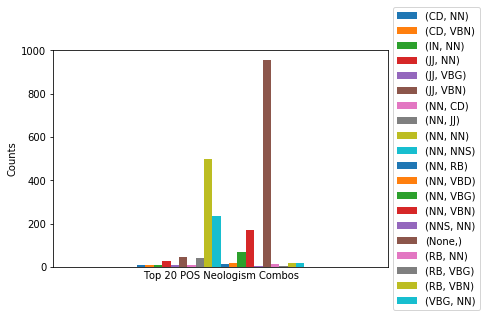

In [23]:
#utility function to plot POS sequence frequencies in neologism data using pandas DataFrame.plot
def plot_neo_tags(neo_tag_counts):
    
    sorted_tags = sorted(neo_tag_counts, key=neo_tag_counts.get, reverse=True)[:20]
    neo_pos_df = pd.DataFrame.from_dict([{tag:neo_tag_counts[tag] for tag in sorted_tags}])
    neo_pos_df.plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.xlabel('Top 20 POS Neologism Combos')
    plt.ylabel('Counts')
    plt.xticks([])
    plt.show()
    

plot_neo_tags(neo_tag_counts)

## Neologism Generation 

Hopefully we can see from this output how we might conjure a crude approximation to Joyce's neologism creation techniques. We'll simply pick a random neologism POS sequence, randomly select 2 words from the english_list until we match our tags, smush the words together, and viola! We're literary geniuses!

In [24]:
def generate_neologism(neo_tags, eng_words):
    
    eng_words = [w for w in eng_words if len(w) > 3]    
    r_neo = randrange(len(neo_tags.keys()))
    neo = list(neo_tags.keys())[r_neo]
    r_neo_tags = neo_tags[list(neo_tags.keys())[r_neo]]
    while r_neo_tags == ('None',):                     
        r_neo = randrange(len(neo_tags.keys()))
        neo = list(neo_tags.keys())[r_neo]
        r_neo_tags = neo_tags[list(neo_tags.keys())[r_neo]]
 
    gen_neo = []
    
    print(f'Random neologism: {neo}, tag_seq: {r_neo_tags}')
    
    for tag in r_neo_tags:
        r_eng = randrange(len(eng_words))
        r_eng_tag = [tag for (word, tag) in nltk.pos_tag(eng_words[r_eng].split())][0]
        while(r_eng_tag != tag or eng_words[r_eng][0].isupper()):
            r_eng = randrange(len(eng_words))
            r_eng_tag = [tag for (word, tag) in nltk.pos_tag(eng_words[r_eng].split())][0]
        gen_neo.append(eng_words[r_eng])
    
    return ''.join(gen_neo)



In [33]:
generate_neologism(neo_tags, english_words)

Random neologism: postagestamps, tag_seq: ('NN', 'NNS')


'geotropismbatekes'

>Well at the very least we learned that it takes more than a simple frequentest algorithm to write like Joyce!